# Simulation

## Étapes générales :
1. Définir les paramètres du système (longueur d'onde, distances focales des lentilles, dimensions des composants, etc).
2. Utiliser la transformée de Fourier pour modéliser l'effet de diffraction sur les lentilles et le réseau.
3. Simuler le trajet de la lumière à travers le système optique en utilisant les fonctions de transfert des composantes du système.
4. Calculer les positions des pics de diffraction et afficher le plan d'imagerie.
5. Générer une figure représentant le spectre de la lumière captée par la caméra, en utilisant le code RGB pour la couleur.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Définir les paramètres du système optique
sampling_interval = 1e-3  # Intervalle d'échantillonnage en mètres, Résolution de l'image 
wavelength = 500e-9  # Longueur d'onde en mètres
grating_period = 600e-3  # Pas du réseau de diffraction en mètres
focal_length_1 = 50e-2
focal_length_2 = 30e-2
beta = 0.1  # Exemple, je ne sais pas encore comment le définir

*input_signal : C'est le champ optique en entrée, généralement une onde lumineuse, représenté sous forme de tableau unidimensionnel (1D) dans notre situation.
grating_period : C'est la période du réseau de diffraction, c'est-à-dire la distance entre les emplacements successifs du réseau. 
wavelength: C'est la longueur d'onde de la lumière incidente. Elle est généralement donnée en unités de longueur, par exemple, en nanomètres*

In [3]:
# Position initiale du rayon lumineux
initial_position = 0  # Ajustable

# Créer une séquence discrète représentant le rayon lumineux (impulsion à la position "initial_position" et zéro partout ailleurs.)
x_values = np.arange(-10, 10, sampling_interval) # Correspond à la largeur de l'image 
initial_wave = np.zeros_like(x_values)
initial_wave[np.abs(x_values - initial_position) < 1e-3] = 1  # Dirac delta-like profile


*On crée ici une séquence discrète initial_wave qui représente un profil spatial de l'intensité lumineuse le long de l'axe x :*

*1. initial_wave = np.zeros_like(x_values): Cette ligne crée un tableau de zéros de même forme que x_values. Initialement, tous les éléments de initial_wave sont définis à zéro.*

*2. initial_wave[np.abs(x_values - initial_position) < 1e-3] = 1 : Cette ligne modifie certains éléments de initial_wave pour créer un profil delta de Dirac-like (c'est-à-dire une impulsion) à une position spécifique initial_position.*

   *- np.abs(x_values - initial_position) < 1e-3 crée un masque booléen qui est "True" pour les indices où la valeur absolue de la différence entre x_values et initial_position est inférieure à \(1 * 10^{-3}\).*

   *- initial_wave[...] = 1 attribue la valeur 1 à tous les éléments de initial_wave pour lesquels le masque est "True", créant ainsi une impulsion à la position spécifiée.**

In [6]:
# Propagation de la lumière à travers le système optique

# 1. Transformation de Fourier pour les lentilles
def lens_transform(input_signal, focal_length, wavelength, sampling_interval):
    spatial_frequencies = np.fft.fftfreq(len(input_signal), sampling_interval)
    lens_transfer_function = np.exp(1j * np.pi * wavelength * focal_length * spatial_frequencies**2)
    output_signal = np.fft.fft(input_signal) * lens_transfer_function
    return np.fft.ifft(output_signal)


# 2. Transformation de Fourier pour le réseau de diffraction
def grating_transform(input_signal, grating_period, wavelength, sampling_interval, beta):

    spatial_frequencies = np.fft.fftfreq(len(input_signal), sampling_interval)
    grating_transfer_function = np.sinc(spatial_frequencies * grating_period) * np.exp(1j * beta * spatial_frequencies)
    output_signal = np.fft.fft(input_signal) * grating_transfer_function
    return np.fft.ifft(output_signal)


*Le principe de la lentille est souvent modélisé par une fonction de phase quadratique. **(Je ne suis pas vraiment sûre, à vérifier avec les profs).***

*Les fonctions "comb" et "rect" ne sont pas explicitement définies ici :*

*1. "Comb" : Le terme "comb" est souvent utilisé pour représenter une série de pics espacés régulièrement, ce qui est similaire à une fonction porte (rectangulaire). Dans le contexte de votre code, la partie "comb" est implémentée par la fonction np.sinc(spatial_frequencies * grating_period). La fonction np.sinc est le sinus cardinal, qui forme une série de pics à des positions espacées en fonction de la fréquence spatiale (spatial_frequencies) et de la période du réseau de diffraction (grating_period).*
*2. "Rect" : La fonction "rect" est souvent associée à une fonction porte, qui est également similaire à une fonction rectangulaire. Ici, la partie "rect" est implémentée par la multiplication de la fonction "comb" (la partie np.sinc) par un terme exponentiel complexe (np.exp(1j * beta * spatial_frequencies)). Ça rajoute une phase à chaque composante fréquentielle, ce qui peut être interprété comme un déplacement spatial de la fente rectangulaire (ou des pics de diffraction) par rapport à la position centrale.*

*En gros, la fonction "comb" est représentée par la partie np.sinc(spatial_frequencies * grating_period) et la fonction "rect" est implémentée par la multiplication de cette fonction par le terme exponentiel complexe np.exp(1j * beta * spatial_frequencies). Ces composantes sont ensuite utilisées pour modéliser l'effet de diffraction du réseau.*

In [7]:
# Propagation à travers la première lentille
wave_after_lens1 = lens_transform(initial_wave, focal_length_1, wavelength, sampling_interval)

# Propagation à travers le réseau de diffraction
wave_after_grating = grating_transform(wave_after_lens1, grating_period, wavelength, sampling_interval, beta)

# Propagation à travers la deuxième lentille
wave_after_lens2 = lens_transform(wave_after_grating, focal_length_2, wavelength, sampling_interval)


# Calcul de la transformée de Fourier du champ optique à la sortie du deuxième élément optique
fourier_transform = np.fft.fft(wave_after_lens2)

# Calcul des fréquences spatiales associées à la transformée de Fourier
spatial_frequencies = np.fft.fftfreq(len(wave_after_lens2), sampling_interval)

*On combine les transformations de Fourier pour chaque élément du système en chaîne et on calcule la transformation de Fourier de l'onde initiale en la passant successivement à travers les lentilles et le réseau de diffraction.*

In [8]:
# Identification des pics de diffraction
seuil = 0.1  # Seuil de détection à ajuster
peaks = (np.fft.fft(wave_after_lens2))
peak_positions = spatial_frequencies[np.abs(peaks) > seuil]

*On utilise la transformée de Fourier discrète sur le champ optique à la sortie du système optiquepour calculer les positions des pics de diffraction sur le plan d'imagerie. La FTT donne les composantes fréquentielles du champ, et les pics de diffraction apparaissent aux positions correspondant aux fréquences spatiales associées aux ordres de diffraction.*

*Le seuil de détection est un paramètre utilisé pour déterminer quels éléments dans la transformée de Fourier doivent être considérés comme significatifs ou "détectés". Il s'agit d'une valeur seuil choisie en fonction du contexte du mandat et du niveau de bruit que vous décidera de tolérer.*

*Dans le contexte de la détection des pics de diffraction, le seuil est utilisé pour filtrer les fréquences spatiales dans la transformée de Fourier. Les pics de diffraction apparaissent sous forme de pics distincts dans le domaine de la fréquence spatiale, et le seuil permet de spécifier une valeur en dessous de laquelle les composantes de fréquence ne sont pas considérées comme significatives.*

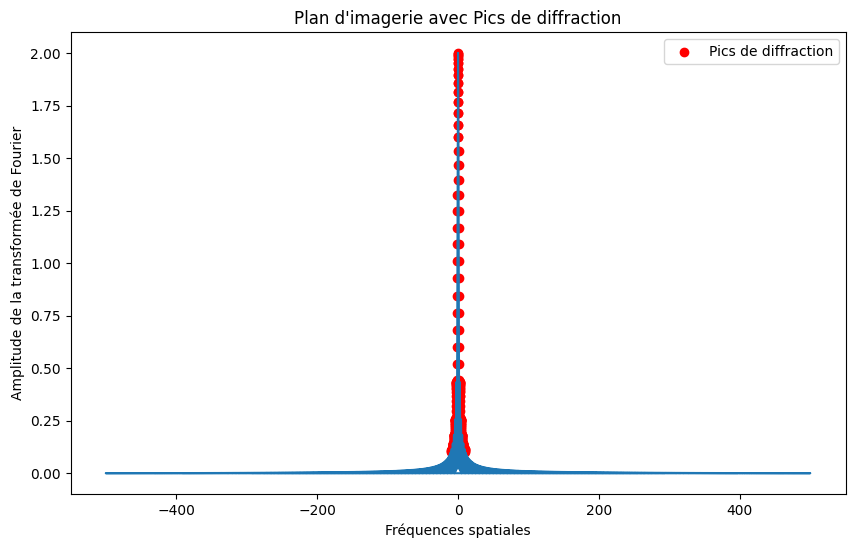

In [9]:
# Affichage du plan d'imagerie
plt.figure(figsize=(10, 6))
plt.plot(spatial_frequencies, np.abs(fourier_transform))
plt.scatter(peak_positions, np.abs(peaks[np.abs(peaks) > seuil]), color='red', label='Pics de diffraction')
plt.title('Plan d\'imagerie avec Pics de diffraction')
plt.xlabel('Fréquences spatiales')
plt.ylabel('Amplitude de la transformée de Fourier')
plt.legend()
plt.show()

(La courbe m'a l'air correcte, mais pas très belle car on n'a pas encore défini les paramètres. )